In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [11]:
df = pd.read_csv("D:/TEL U/S2 TELU/SEM 2 TELU/MATLANJUT/CODE1/td.csv")

df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])

X = df.drop('Survived', axis=1)
y = df['Survived']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12036\174186719.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12036\174186719.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [12]:
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(
        units=hp.Choice('units_input', [32, 64, 128]),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))

    if hp.Boolean('use_hidden_layer'):
        model.add(Dense(
            units=hp.Choice('units_hidden', [32, 64, 128]),
            activation='relu'
        ))

    model.add(Dense(1, activation='sigmoid'))

    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [13]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='adam_hyperband',
    project_name='titanic_adagrad'
)

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

Trial 76 Complete [00h 00m 03s]
val_accuracy: 0.8391608595848083

Best val_accuracy So Far: 0.8601398468017578
Total elapsed time: 00h 02m 12s


In [15]:
best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)

history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7087 - loss: 0.5799 - val_accuracy: 0.8392 - val_loss: 0.4027
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8140 - loss: 0.4581 - val_accuracy: 0.8252 - val_loss: 0.3827
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8083 - loss: 0.4480 - val_accuracy: 0.8462 - val_loss: 0.3954
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8219 - loss: 0.4081 - val_accuracy: 0.8252 - val_loss: 0.4116
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8485 - loss: 0.3904 - val_accuracy: 0.8531 - val_loss: 0.3901
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8261 - loss: 0.3881 - val_accuracy: 0.8252 - val_loss: 0.4165
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8622 - loss: 0.3829 - val_accuracy: 0.8462 - val_loss: 0.3965
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8343 - loss: 0.3886 - val_accuracy: 0.8392 - val_loss

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Grid Search - Test Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8463 - loss: 0.4840 
✅ Grid Search - Test Accuracy: 0.8492
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88       105
           1       0.86      0.76      0.81        74

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179

Confusion Matrix:
 [[96  9]
 [18 56]]


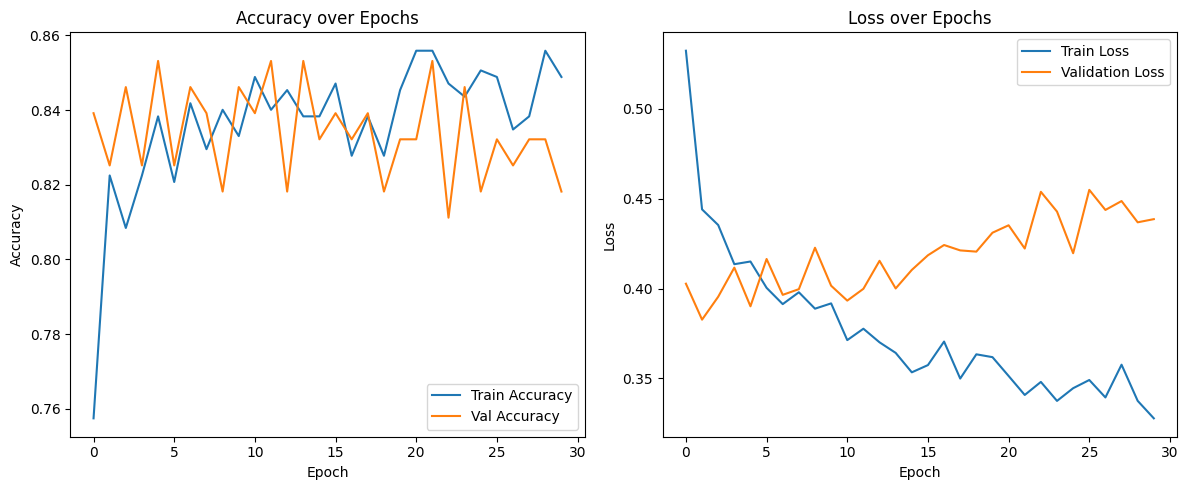

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


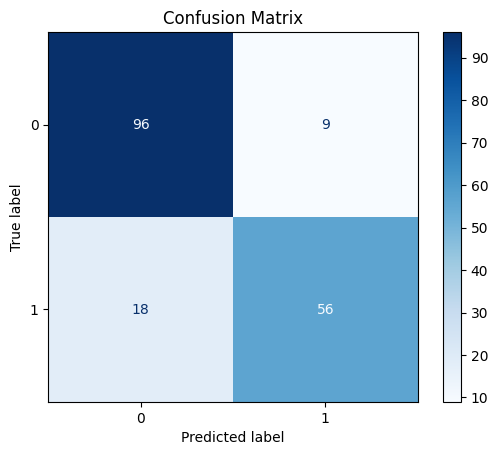

In [18]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()